In [1]:
import numpy as np
import math
import random
from scipy.stats import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
class KinematicModel:

    def __init__(self, L, y, theta, Lmax, l, d, p1, sigmaC, p2):
        self.L = L
        self.y = y
        self.theta = theta
        self.Lmax = Lmax
        self.l = l
        self.d = d
        self.p1 = p1
        self.sigmaC = sigmaC
        self.p2 = p2
        self.nCurves = 0

    def input(self, action):
        noise = norm.rvs(loc=0, scale=action[0] / 4)
        self.y = self.y + action[0] * math.sin(math.radians(action[1] + noise + self.theta))
        nextVehicleEvent = random.uniform(0, 1)
        if nextVehicleEvent < self.p2:
            self.d = self.d + (self.l - action[0] * math.cos(math.radians(action[1] + noise + self.theta)))
        else:
            self.d = 40
        self.theta = self.theta + (action[0] / self.L) * math.tan(math.radians(action[1] + noise))
        curveEvent = random.uniform(0, 1)
        if curveEvent < self.p1:
            self.nCurves += 1
            curveAngle = norm.rvs(loc=0, scale=self.sigmaC)
            self.theta = self.theta + curveAngle
            
            
    def __str__(self):
        return f"y = {self.y:.2f} / theta = {self.theta:.2f} / d = {self.d:.2f}"

In [3]:
# Probability of going out of a straight road given an action 
def P1(action, environment, sigma, show = True):
    if (environment.Lmax - environment.y) / action[0] > 1 or (environment.Lmax - environment.y) / action[0] < -1:
        term1 = 0
    # Term 1 is the probability that y > Lmax
    else:
        term1 = math.degrees(math.asin((environment.Lmax - environment.y) / action[0]))
        term1 = 1 - norm.cdf((1 / sigma) * (term1 - action[1] - environment.theta))
    #print(f"Term 1: {term1}")
    # Term 2 is the probability that y < -Lmax
    if (- environment.Lmax - environment.y) / action[0] > 1 or (- environment.Lmax - environment.y) / action[0] < -1:
        term2 = 0
    else:
        term2 = math.degrees(math.asin((- environment.Lmax - environment.y) / action[0]))
        term2 = norm.cdf((1 / sigma) * (term2 - action[1] - environment.theta))
    #print(f"Term 2: {term2}")
    value = (1 - environment.p1) * (term1 + term2)
    if show:
        print(f"Value: {value}")
    return value, term1, term2
    
# Probability of going out of a curved road given an action
def P2(action, environment, sigma, show = True):
    # Term 1 is the probability that y > Lmax
    if (environment.Lmax - environment.y) / action[0] > 1 or (environment.Lmax - environment.y) / action[0] < -1:
        term1 = 0
    else:
        term1 = math.degrees(math.asin((environment.Lmax - environment.y) / action[0]))
        term1 = 1 - norm.cdf((1 / sigma) * (term1 - action[1] - environment.theta))
    #print(f"Term 1: {term1}")
    # Term 2 is the probability that y < -Lmax
    if (- environment.Lmax - environment.y) / action[0] > 1 or (- environment.Lmax - environment.y) / action[0] < -1:
        term2 = 0
    else:
        term2 = math.degrees(math.asin((- environment.Lmax - environment.y) / action[0]))
        term2 = norm.cdf((1 / sigma) * (term2 - action[1] - environment.theta))
    #print(f"Term 2: {term2}")
    value = environment.p1 * (term1 + term2)
    if show:
        print(f"Value: {value}")
    return value, term1, term2

# Probability of risking a crash in a straight road given an action 
def P3(action, environment, sigma, show = True):
    if (1 / action[0]) * (environment.l + ( ((action[0] * 3.6) / -2) + environment.d)) > 1:
        return 0
    value = math.degrees(math.acos((1 / action[0]) * (environment.l + (((action[0] * 3.6) / -2) + environment.d))))
    value = norm.cdf((1 / sigma) * (value - math.fabs(action[1]) - math.fabs(environment.theta)))
    value = environment.p2 * (1 - environment.p1) * value
    if show:
        print(f"Value: {value}")
    return value

# Probability of risking a crash in a curved road given an action
def P4(action, environment, sigma, show = True):
    if (1 / action[0]) * (environment.l + ( ((action[0] * 3.6) / -2) + environment.d)) > 1:
        return 0
    value = math.degrees(math.acos((1 / action[0]) * (environment.l + (((action[0] * 3.6) / -2) + environment.d))))
    value = norm.cdf((1 / sigma) * (value - math.fabs(action[1]) - math.fabs(environment.theta)))
    value = environment.p2 * environment.p1 * value
    if show:
        print(f"Value: {value}")
    return value

In [6]:
# Reward for staying at the center of the road
def rewardCenterProbability(action, environment, ratio, show = True):
    # Term 1 is the probability that y < Lmax * ratio
    if ((environment.Lmax * ratio) - environment.y) / action[0] > 1 or ((environment.Lmax * ratio) - environment.y) / action[0] < -1:
        term1 = 0
        term1C = 0
    else:
        term1 = math.degrees(math.asin(((environment.Lmax * ratio) - environment.y) / action[0]))
        term1C = norm.cdf((1 / (math.sqrt(action[0]/4 + environment.sigmaC))) * (term1 - action[1] - environment.theta))
        term1 = norm.cdf((1 / (action[0]/4)) * (term1 - action[1] - environment.theta))
    #print(f"Term 1: {term1}")
    # Term 2 is the probability that y > -Lmax * ratio
    if ((-environment.Lmax * ratio) - environment.y) / action[0] > 1 or ((-environment.Lmax * ratio) - environment.y) / action[0] < -1:
        term2 = 0
        term2C = 0
    else:
        term2 = math.degrees(math.asin(((-environment.Lmax * ratio) - environment.y) / action[0]))
        term2C = norm.cdf((1 / (math.sqrt(action[0]/4 + environment.sigmaC))) * (term2 - action[1] - environment.theta))
        term2 = norm.cdf((1 / (action[0]/4)) * (term2 - action[1] - environment.theta))
    #print(f"Term 2: {term2}")
    value = ((1 - environment.p1) * (term1 - term2)) + (environment.p1 * (term1C - term2C))
    if show:
        print(f"Value: {value}")
    return value

# Reward for going at the correct speed
def rewardSpeed(action, environment):
    return -0.05 * (math.fabs(environment.l - action[0]))

def breakDistanceProbability(action, environment):
    # Probability of risking a crash in a straight road given an action 
    term1 = P3(action, environment, action[0] / 4, False)
    #Probability of risking a crash in a curved road given an action
    term2 = P4(action, environment, math.sqrt(action[0]/4 + environment.sigmaC), False)
    return term1 + term2

def outOfRoadProbability(action, environment):
    # Probability of going out of a straight road given an action
    term1, _, _ = P1(action, environment, action[0]/4, False)
    # Probability of going out of a curved road given an action
    term2, _, _ = P2(action, environment, action[0]/4, False)
    return term1 + term2

# Expected reward given an action
def expectedReward(action, environment, r1, r2, show = True):
    termR1 = r1 * rewardCenterProbability(action, environment, 0.5, False)
    #print(f"Term r1: {termR1}")
    termR2 = r2 * rewardCenterProbability(action, environment, 0.25, False)
    #print(f"Term r2: {termR2}")
    rSpeed = rewardSpeed(action, environment)
    if show:
        print(f"Reward for action [{action[0]}, {action[1]}]: {round(termR1 + termR2 + rSpeed, 2)}")
    return termR1 + termR2 + rSpeed

def expectedSafeReward(action, environment, r1, r2, r3, r4, r5, r6, show = True):
    termR1 = r1 * rewardCenterProbability(action, environment, 0.5, False)
    #print(f"Term r1: {termR1}")
    termR2 = r2 * rewardCenterProbability(action, environment, 0.25, False)
    #print(f"Term r2: {termR2}")
    rSpeed = rewardSpeed(action, environment)
    termR3 = r3 * (1 - breakDistanceProbability(action, environment))
    #print(f"Term r3: {termR3}")
    termR4 = r4 * breakDistanceProbability(action, environment)
    #print(f"Term r4: {termR4}")
    termR5 = r5 * (1 - outOfRoadProbability(action, environment))
    termR6 = r6 * outOfRoadProbability(action, environment)
    if show:
        print(f"Reward for action [{action[0]}, {action[1]}]: {round(termR1 + termR2 + rSpeed + termR3 + termR4 + termR5 + termR6, 2)}")
    return termR1 + termR2 + rSpeed + termR3 + termR4 + termR5 + termR6

# (NON-SAFE) Iterates over all possible actions and returns the best one with the highest expected reward
def findBestAction(actions, environment, r1, r2):
    bestAction = None
    bestExpectedReward = float('-inf')
    for action in actions:
        reward = expectedReward(action, environment, r1, r2, show=False)
        if reward > bestExpectedReward:
            bestExpectedReward = reward
            bestAction = action
    return bestAction, bestExpectedReward

# (SAFE) Iterates over all possible actions and returns the best one with the highest expected reward
def findBestSafeAction(actions, environment, r1, r2, r3, r4, r5, r6):
    bestAction = None
    bestExpectedReward = float('-inf')
    for action in actions:
        reward = expectedSafeReward(action, environment, r1, r2, r3, r4, r5, r6, show=False)
        if reward > bestExpectedReward:
            bestExpectedReward = reward
            bestAction = action
    return bestAction, bestExpectedReward

Initial state: y = 0.00 / theta = 0.00 / d = 40.00
# of curves in track NON SAFE: 6
Average NON SAFE speed: 24.2
# of times safety constraints where broken in NON SAFE: 69
Initial state: y = 0.00 / theta = 0.00 / d = 40.00
# of curves in track SAFE: 8
Average SAFE speed: 20.95
# of times safety constraints where broken in SAFE: 48


<Figure size 1200x1000 with 0 Axes>

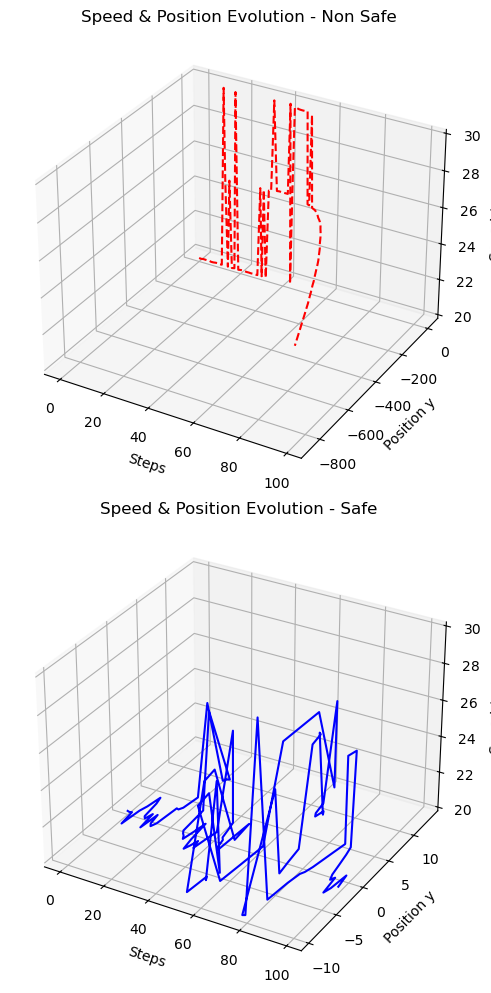

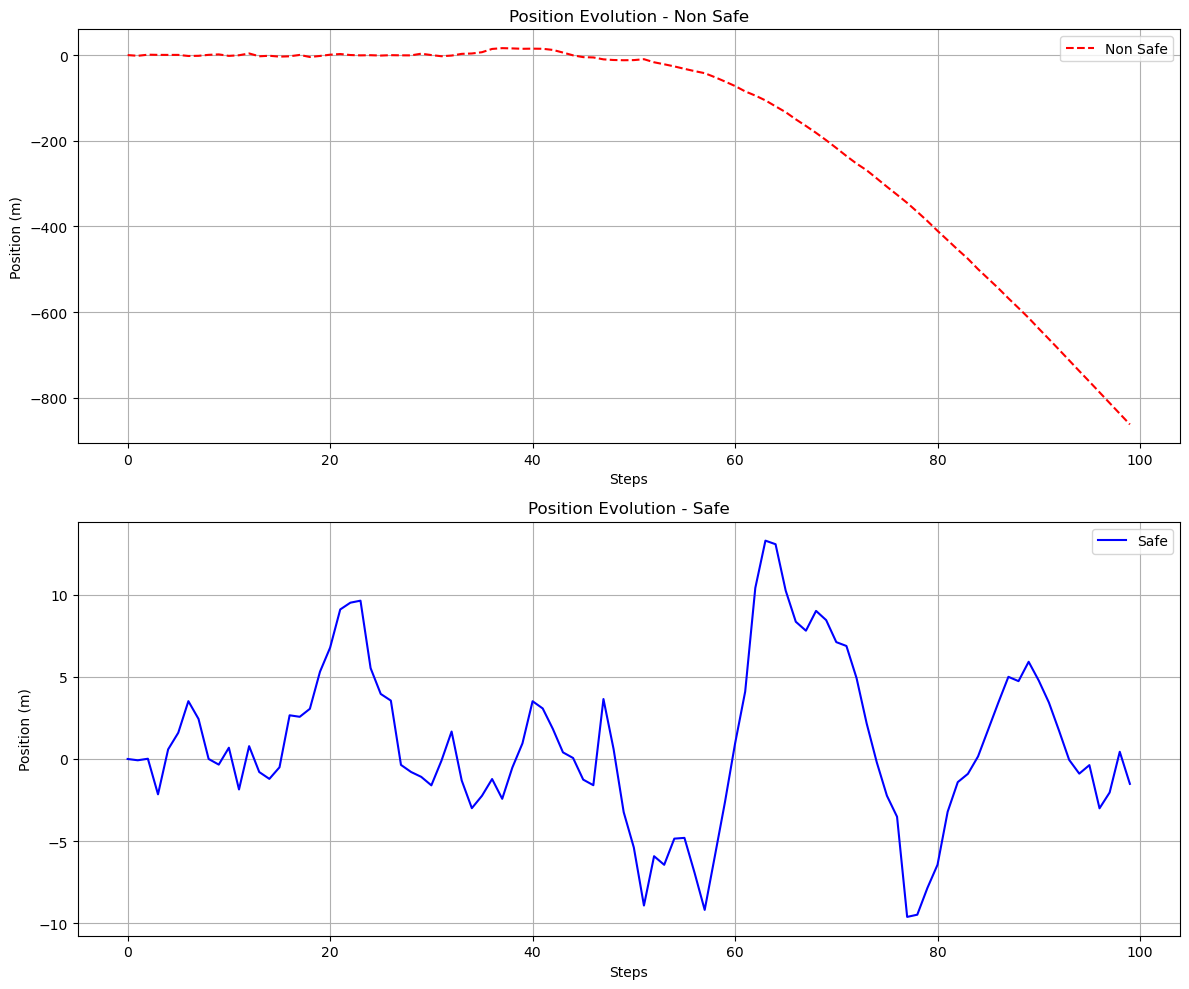

In [ ]:
# State space
# 0 = S_G: good state
# 1 = S_X: out of road state
# 2 = S_I: risk of crash state
# 3 = S_XI: out of road and risk of crash state
states = ['G', 'X', 'I', 'XI']

# Action space
anglesDeg = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
velocities = [20, 25, 30]
actions = [(v, delta) for v in velocities for delta in anglesDeg]

# Reward weights
r1 = 50
r2 = 100
r3 = 0
r4 = -500 # breakDistanceProbability
r5 = 0
r6 = -500 # outOfRoadProbability

# Environment starts:
# - At center of the road y = 0 m
# - Aligned with the road theta = 0°
# - Road width 4 m Lmax = 2 m
# - Road limit 90 km/h l = 25 m/s
# - Distance from next vehicle d = 40 m
# - Probability of a road curve p1 = 5%
# - Variance of the curve sigmaC = 5
# - Probability of a vehicle in front p2 = 30%

# Number of steps
steps = 100

# -------- Simulation NON SAFE --------------
kinematicModel = KinematicModel(L = 1, y = 0, theta = 0, Lmax = 3, l = 25, d = 40, p1 = 0.05, sigmaC = 5, p2 = 0.3)
print(f"Initial state: {kinematicModel}")
averageSpeed = 0
speedsNonSafe = []
positionsNonSafe = []
constraintsBreakNonSafe = 0
for step in range(steps):
    #print(f"STEP {step}")
    # Find the best action based on the current environment state (using the reward function for non-safe driving).
    action, reward = findBestAction(actions, kinematicModel, r1, r2)
    averageSpeed += action[0]
    speedsNonSafe.append(action[0])
    positionsNonSafe.append(kinematicModel.y)
    # Checks if the vehicle has gone beyond the allowable lateral boundaries of the road
    if kinematicModel.y > kinematicModel.Lmax or kinematicModel.y < -kinematicModel.Lmax:
        constraintsBreakNonSafe += 1
    #print(f"Chosen action {action} with reward {reward:.2f}")
    # This updates the state of the kinematicModel based on the chosen action
    kinematicModel.input(action)
    #print(f"Model state at step: {kinematicModel}")

print(f"# of curves in track NON SAFE: {kinematicModel.nCurves}")
print(f"Average NON SAFE speed: {averageSpeed / steps}")
print(f"# of times safety constraints where broken in NON SAFE: {constraintsBreakNonSafe}")

# ----------  Simulation SAFE ------------
kinematicModel = KinematicModel(L = 1, y = 0, theta = 0, Lmax = 3, l = 25, d = 40, p1 = 0.05, sigmaC = 5, p2 = 0.3)
print(f"Initial state: {kinematicModel}")
averageSpeed = 0
speedsSafe = []
positionsSafe = []
constraintsBreakSafe = 0
for step in range(steps):
    #print(f"STEP {step}")
    action, reward = findBestSafeAction(actions, kinematicModel, r1, r2, r3, r4, r5, r6)
    averageSpeed += action[0]
    speedsSafe.append(action[0])
    positionsSafe.append(kinematicModel.y)
    if kinematicModel.y > kinematicModel.Lmax or kinematicModel.y < -kinematicModel.Lmax:
        constraintsBreakSafe += 1
    #print(f"Chosen action {action} with reward {reward:.2f}")
    kinematicModel.input(action)
    #print(f"Model state at step: {kinematicModel}")

print(f"# of curves in track SAFE: {kinematicModel.nCurves}")
print(f"Average SAFE speed: {averageSpeed / steps}")
print(f"# of times safety constraints where broken in SAFE: {constraintsBreakSafe}")

plt.figure(figsize=(12, 10))

fig = plt.figure(figsize=(14, 10))

# Grafico 3D per la simulazione NON SAFE
ax1 = fig.add_subplot(2, 1, 1, projection='3d')
ax1.plot3D(range(steps), positionsNonSafe, speedsNonSafe, linestyle="dashed", color="red")
ax1.set_xlabel("Steps")
ax1.set_ylabel("Position y")
ax1.set_zlabel("Speed (m/s)")
ax1.set_title("Speed & Position Evolution - Non Safe")

# Grafico 3D per la simulazione SAFE
ax2 = fig.add_subplot(2, 1, 2, projection='3d')
ax2.plot3D(range(steps), positionsSafe, speedsSafe, linestyle="solid", color="blue")
ax2.set_xlabel("Steps")
ax2.set_ylabel("Position y")
ax2.set_zlabel("Speed (m/s)")
ax2.set_title("Speed & Position Evolution - Safe")

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 10))

# Grafico per la simulazione NON SAFE
plt.subplot(2, 1, 1)  # (righe, colonne, indice)
plt.plot(range(steps), positionsNonSafe, label="Non Safe", linestyle="dashed", color="red")
plt.xlabel("Steps")
plt.ylabel("Position (m)")
plt.title("Position Evolution - Non Safe")
plt.legend()
plt.grid()

# Grafico per la simulazione SAFE
plt.subplot(2, 1, 2)
plt.plot(range(steps), positionsSafe, label="Safe", linestyle="solid", color="blue")
plt.xlabel("Steps")
plt.ylabel("Position (m)")
plt.title("Position Evolution - Safe")
plt.legend()
plt.grid()

# Mostra i grafici
plt.tight_layout()
plt.show()

# of average speed for all simulations: 250
# of average speed for each set of simulations: 5
Average speeds: [23.08599999999999, 21.120999999999995, 20.844, 20.672000000000008, 20.521000000000004]
# constraints breaks for all simulations: 250
# of average constraints breaks for each set of simulations: 5
Average speeds: [46.42, 35.56, 35.6, 33.52, 31.8]


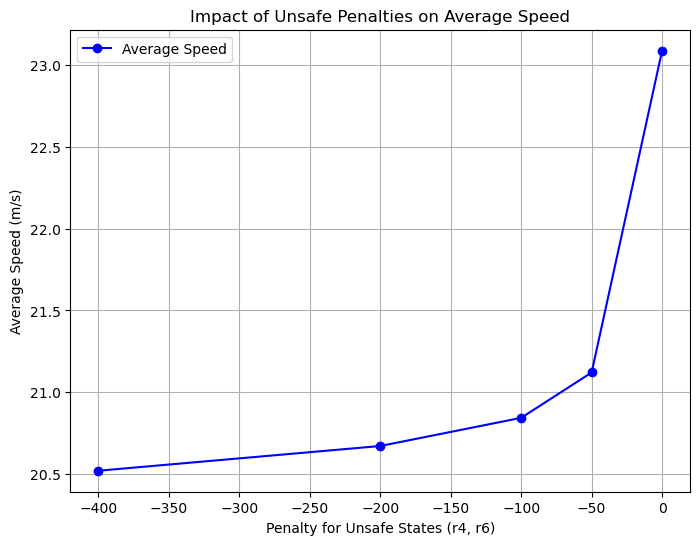

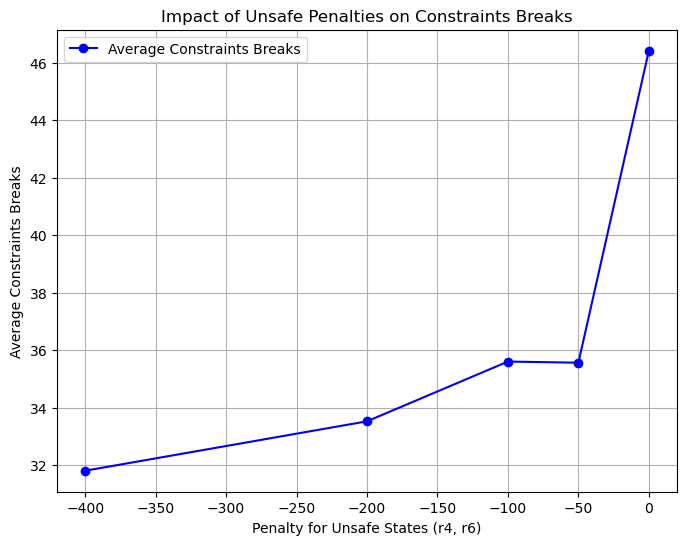

In [ ]:
simulations = 50 # number of simulations to run for each penalty value (r4_6Values
steps = 100 # number of steps for each simulation
r4_6Values = [0, -50, -100, -200, -400] # list of different penalty values for unsafe states
simulationsSpeeds = [] # list of average speeds for each simulation
simulationsConstraintsBreaks = [] 

for value in r4_6Values: # Loops over each penalty (allows testing the system under different penalty conditions.)
    for simulation in range(simulations): # For each penalty, run the simulation multiple times (50 times)
        kinematicModel = KinematicModel(L = 1, y = 0, theta = 0, Lmax = 3, l = 25, d = 40, p1 = 0.05, sigmaC = 5, p2 = 0.3)
        averageSpeed = 0
        constraintsBreaks = 0
        for step in range(steps): # For each simulation, run the simulation for a number of steps (100 steps)
            action, reward = findBestSafeAction(actions, kinematicModel, r1, r2, r3, value, r5, value) 
            averageSpeed += action[0]
            if kinematicModel.y > kinematicModel.Lmax or kinematicModel.y < -kinematicModel.Lmax:
                constraintsBreaks += 1
            kinematicModel.input(action)
        averageSpeed = averageSpeed / steps
        simulationsSpeeds.append(averageSpeed)
        simulationsConstraintsBreaks.append(constraintsBreaks)

# Function used to split the data into groups of 50 (to get average speed and avg constraintsbrak for each set of 50 simulations)
def meanSets(data, group_size=50):
    return [sum(data[i:i+group_size]) / group_size for i in range(0, len(data), group_size)]

# Calculates the average speed for each set of simulations
averageSpeeds = meanSets(simulationsSpeeds, simulations)
averageConstraintsBreaks = meanSets(simulationsConstraintsBreaks, simulations)

print(f"# of average speed for all simulations: {len(simulationsSpeeds)}")
print(f"# of average speed for each set of simulations: {len(averageSpeeds)}")
print(f"Average speeds: {averageSpeeds}")
print(f"# constraints breaks for all simulations: {len(simulationsConstraintsBreaks)}")
print(f"# of average constraints breaks for each set of simulations: {len(averageConstraintsBreaks)}")
print(f"Average speeds: {averageConstraintsBreaks}")

plt.figure(figsize=(8, 6))
plt.plot(r4_6Values, averageSpeeds, marker='o', linestyle='-', color='b', label="Average Speed")
plt.xlabel("Penalty for Unsafe States (r4, r6)")
plt.ylabel("Average Speed (m/s)")
plt.title("Impact of Unsafe Penalties on Average Speed")
plt.grid(True)
plt.legend()
plt.savefig("graph1.pdf")
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(r4_6Values, averageConstraintsBreaks, marker='o', linestyle='-', color='b', label="Average Constraints Breaks")
plt.xlabel("Penalty for Unsafe States (r4, r6)")
plt.ylabel("Average Constraints Breaks")
plt.title("Impact of Unsafe Penalties on Constraints Breaks")
plt.grid(True)
plt.legend()
plt.savefig("graph2.pdf")
plt.show()